<h1 style="text-align: center">
Deep Learning HW2 </br> 
Image Classification
</h1>

### Full Name: Arya Jalali
### Student ID: 98105665

## Import needed libraries


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report

## Loading and Pre-Processing data

In [51]:
## Download FashionMNIST dataset
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# use fashion mnist dataset

transformation = transforms.Compose ([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])
])

train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform = transformation)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform = transformation)
#################################################################################
#                                   THE END                                     #
#################################################################################

In [52]:
print(test_set)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.1307], std=[0.3081])
           )


In [53]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# split training set into train and validation data
train_size = 48000
val_size = 60000 - train_size
train_ds,val_ds = train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

#################################################################################
#                                   THE END                                     #
#################################################################################

In [55]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Loading the dataset into memory using Dataloader
# use your desired batch size and shuffle is necessary
BATCH = 64
train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle = True)
val_dataloader = DataLoader(val_ds, batch_size = 64, shuffle = False)
test_dataloader = DataLoader(test_set, batch_size = 64, shuffle = False)
classes = train_set.classes

#################################################################################
#                                   THE END                                     #
#################################################################################

**Display some images from dataset**

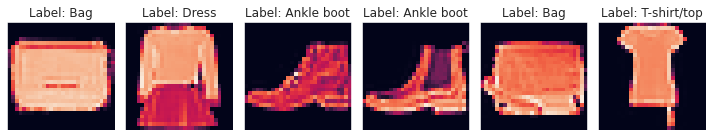

In [56]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,6),axes.flat):
    img,label=images[i],labels[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Label: {classes[label]}")

plt.tight_layout()
plt.show()

# Defining the Convolutional Neural Network

<img src='https://drive.google.com/uc?id=1Euy5_bGIiiYECSZUeEofgTImJWgQ0XLf'>

**<h2>Implement the model above in pytorch</h2>**

In [57]:
import torch.nn as nn
import torch.nn.functional as F

#define the CNN architecture below
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
        )
        self.fc1 = nn.Linear(2304, 600)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)



#################################################################################
#                                   THE END                                     #
#################################################################################
        
        
    def forward(self, x):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)



#################################################################################
#                                   THE END                                     #
#################################################################################
        
        return out

In [58]:
# Using GPU if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
cnn_model = Net()
cnn_model.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

# Defining Loss Function and optimizer
**Define appropriate Loss Function, Optimizer and Learning Rate**

In [60]:
import torch.optim as optim

Learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=Learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

**Define number of epochs and path to save the best model**

In [61]:
epochs = 10
save_path="/content/cnn_model"

# Finally we will train our neural network

In [62]:
# multiclass accuracy
def multi_acc(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

**Implementing the training algorithm and Saving the model with minimum Validation Loss**

In [63]:
# training loop
def train_model(model, train_dataloader, val_dataloader, n_epochs, optimizer, criterion, device, save_path):
    train_losses = []
    val_losses = []
    valid_loss_min = np.Inf 

    for epoch in range(n_epochs):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        ####### Training Phase ########
        model.train()
        with tqdm(train_dataloader, unit="batch") as batches:
            epoch_loss = 0
            for data, target in batches:
                batches.set_description(f"Epoch {epoch + 1}")

                # move to GPU
                data = data.to(device)
                target = target.to(device)
                # train 
                out = cnn_model(data)
                loss = criterion(out, target)
                optimizer.zero_grad()
                loss.backward()
                epoch_loss += loss.item()
                optimizer.step()

                acc = multi_acc(out, target)
                batches.set_postfix(train_loss = loss.item(), train_accuracy = acc.item()) # show loss and accuracy per batch of data
        epoch_loss = epoch_loss / len(train_dataloader)
        # scheduler.step()
        train_losses.append(epoch_loss)

        epoch_loss = 0


        ####### Validation Phase ########
        model.eval()
        with torch.no_grad():
            # run the prediction on the validation dataloader,
            y_true, y_pred = [], []
            for batch_idx, (data, target) in enumerate(val_dataloader):
                # move to GPU
                data = data.to(device)
                target = target.to(device)
                # validation
                out = cnn_model(data)
                loss = criterion(out, target)
                epoch_loss += loss.item()

        valid_loss = epoch_loss / len(val_dataloader)

#################################################################################
#                                   THE END                                     #
#################################################################################
        val_losses.append(valid_loss)
        
        # print validation statistics 
        print('Epoch: {}  Validation Loss: {:.6f}'.format(epoch+1, valid_loss))

        ## If the valiation loss has decreased, then saving the model
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 
    model.load_state_dict(torch.load(save_path))
    return model, train_losses, val_losses

**Train the model**

In [64]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
(model, train_losses, val_losses) = train_model(cnn_model,train_dataloader, val_dataloader, epochs, optimizer,
                                                criterion, device, save_path)
#################################################################################
#                                   THE END                                     #
#################################################################################

Epoch 1: 100%|██████████| 750/750 [00:21<00:00, 34.72batch/s, train_accuracy=86, train_loss=0.41]


Epoch: 1  Validation Loss: 0.306173
Validation loss decreased (inf --> 0.306173).  Saving model ...


Epoch 2: 100%|██████████| 750/750 [00:21<00:00, 34.73batch/s, train_accuracy=88, train_loss=0.338]


Epoch: 2  Validation Loss: 0.305294
Validation loss decreased (0.306173 --> 0.305294).  Saving model ...


Epoch 3: 100%|██████████| 750/750 [00:21<00:00, 34.86batch/s, train_accuracy=94, train_loss=0.23]


Epoch: 3  Validation Loss: 0.319530


Epoch 4: 100%|██████████| 750/750 [00:21<00:00, 34.90batch/s, train_accuracy=94, train_loss=0.161]


Epoch: 4  Validation Loss: 0.288749
Validation loss decreased (0.305294 --> 0.288749).  Saving model ...


Epoch 5: 100%|██████████| 750/750 [00:21<00:00, 34.95batch/s, train_accuracy=95, train_loss=0.184]


Epoch: 5  Validation Loss: 0.306226


Epoch 6: 100%|██████████| 750/750 [00:22<00:00, 33.11batch/s, train_accuracy=92, train_loss=0.116]


Epoch: 6  Validation Loss: 0.238594
Validation loss decreased (0.288749 --> 0.238594).  Saving model ...


Epoch 7: 100%|██████████| 750/750 [00:21<00:00, 34.40batch/s, train_accuracy=86, train_loss=0.369]


Epoch: 7  Validation Loss: 0.266846


Epoch 8: 100%|██████████| 750/750 [00:21<00:00, 34.81batch/s, train_accuracy=95, train_loss=0.147]


Epoch: 8  Validation Loss: 0.250298


Epoch 9: 100%|██████████| 750/750 [00:21<00:00, 34.22batch/s, train_accuracy=94, train_loss=0.187]


Epoch: 9  Validation Loss: 0.259899


Epoch 10: 100%|██████████| 750/750 [00:21<00:00, 34.76batch/s, train_accuracy=92, train_loss=0.234]


Epoch: 10  Validation Loss: 0.288181


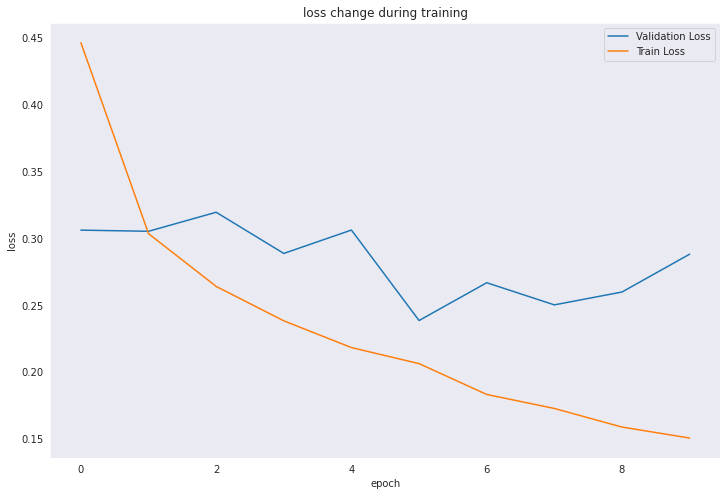

In [65]:
# plot losses
plt.subplots(figsize=(12, 8))
sns.set_style("dark")
sns.lineplot(data=val_losses,label="Validation Loss")
sns.lineplot(data=np.asarray(train_losses),label="Train Loss").set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.legend()
plt.show()

# Prediction on Test Data

In [66]:
def predict(images, model):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
    out = model(images)
    _, predicted = torch.max(out.data, 1)
#################################################################################
#                                   THE END                                     #
#################################################################################  
    return predicted

**Accuracy Result on Test Data**

In [67]:
correct = 0
total = 0
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for data in test_dataloader:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        predicted = predict(images, cnn_model)
#################################################################################
#                                   THE END                                     #
#################################################################################   
        for  x in predicted.cpu().numpy(): y_pred_list.append(x)
        for  x in labels.cpu().numpy(): y_true_list.append(x)
total = len(y_true_list)
correct = np.sum(np.array(y_pred_list) == np.array(y_true_list))

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 91 %


**Classification report**

In [68]:
print(classification_report(y_true_list, y_pred_list, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.85      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.90      0.83      0.87      1000
       Dress       0.92      0.89      0.91      1000
        Coat       0.83      0.92      0.87      1000
      Sandal       0.97      0.99      0.98      1000
       Shirt       0.74      0.76      0.75      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.99      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



**Displaying a random set of images from test data**

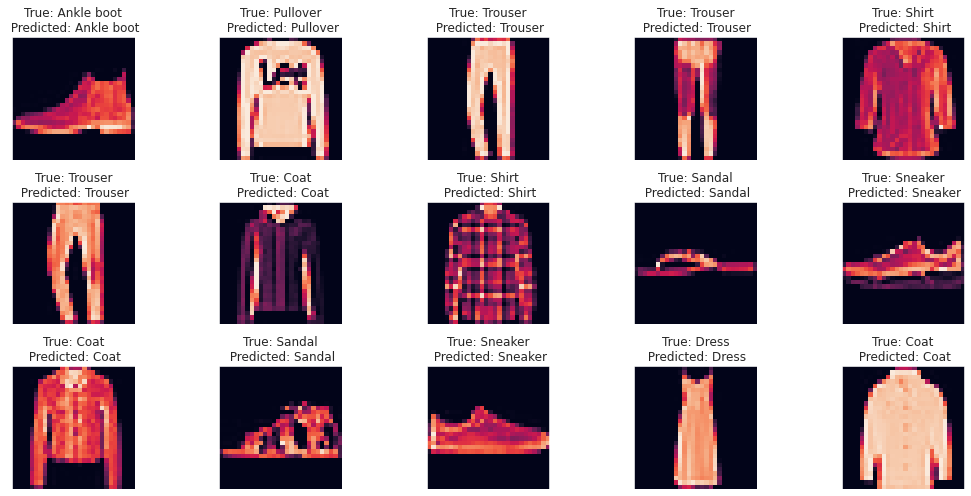

In [69]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
predicted=predict(images.to(device),cnn_model)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,16),axes.flat):
    img,label=images[i],labels[i]
    pred=predicted[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {classes[label]}\n Predicted: {classes[pred]}")

plt.tight_layout()
plt.show()